# Deep Q-Learning

In [29]:
from collections import defaultdict
import numpy as np 
import random
import gymnasium as gym
import sys
sys.path.append('../')

env = gym.make("Blackjack-v1")

obs, info = env.reset() # initialize the environment

# obs is are input to the neural network 
# (player_sum, dealer_card, usable_ace)
obs

(17, 3, 0)

Defining the Neural Network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, input_dim=3, output_dim=2):  # 2 actions: hit or stick
        super(QNetwork, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        out = self.fnn(x)
        return out
    
# (player_sum, dealer_card, usable_ace)
q_net = QNetwork(len(obs), 2)

One forward pass test

In [35]:
action_probability_distribution = q_net(torch.FloatTensor(obs))
torch.argmax(action_probability_distribution).item()

0

Create an Deep Q Agent

In [36]:
class Agent:
    def __init__(self, params):
        self.params = params

        # Use CUDA if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.q_net = QNetwork(3, 2).to(self.device) 
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.params['lr'])

    def tensor(self, obs):
        return torch.FloatTensor(obs).to(self.device)

    @torch.no_grad()
    def greedy_action(self, obs):
        """ Greedy Policy """
        if np.random.random() < self.params['e']:
            return random.choice([0, 1])
        else:
            obs_tensor = self.tensor(obs)
            probs = self.q_net(obs_tensor)
            action = torch.argmax(probs).item()
            return action

    def decay(self):
        self.params['e'] = max(0.01, self.params['e'] - 0.001)

    def update(self, current_state, next_state, reward, action, termination):
        """ Q - Learning """
        state_tensor = self.tensor(current_state)
        q_values = self.q_net(state_tensor)
        current_q = q_values[action]

        with torch.no_grad():
            next_tensor = self.tensor(next_state)
            next_q = torch.max(self.q_net(next_tensor))
            td_target = reward + self.params['discount'] * next_q * (1 - int(termination))

        loss = self.criterion(current_q, td_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.decay()

        return loss.item()

    def generate_q_table(self, usable_ace=False):
        """Generate a tabular Q-value dict for plotting."""
        self.q_values = {}
        for player_sum in range(12, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                state_tensor = self.tensor(state)
                with torch.no_grad():
                    q_vals = self.q_net(state_tensor)
                self.q_values[state] = q_vals.cpu().numpy() 

params = {'discount': 0.2, 'lr': 0.001, 'e': 0.05}
agent = Agent(params)
losses = []

for episode in range(20_000):
    current_state, _ = env.reset()
    done = False

    while not done:
        action = agent.greedy_action(current_state)
        next_state, reward, termination, truncated, info = env.step(action)
        done = termination or truncated
        loss = agent.update(current_state, next_state, reward, action, termination)
        losses.append(loss)

***

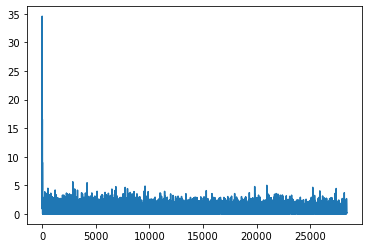

In [37]:
import matplotlib.pyplot as plt

plt.plot(losses)

***

Evaluations

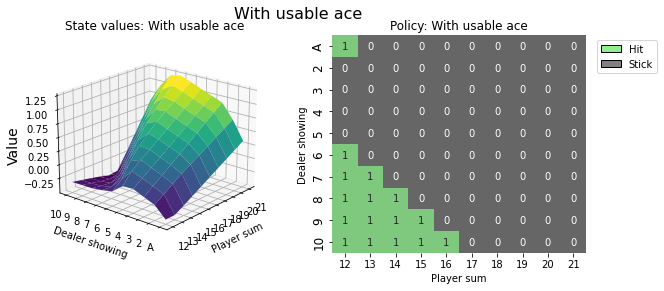

In [38]:
from modules.utils import * 

agent.generate_q_table(usable_ace=True)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

np.save('../checkpoints/Deep_Q_learning.npy', policy_grid)


In [ ]:
usable_ace = True
policy_grid = defaultdict(int)
for obs, action_values in policy.q_values.items():
    policy_grid[obs] = action_values

player_count, dealer_count = np.meshgrid(
    # players count, dealers face-up card
    np.arange(12, 22),
    np.arange(1, 11),
)

# create the policy grid for plotting
policy_grid = np.apply_along_axis(
    lambda obs: policy_grid[(obs[0], obs[1], usable_ace)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)

np.save('../checkpoints/AC_Policy_Gradient.npy', policy_grid)
policy_grid

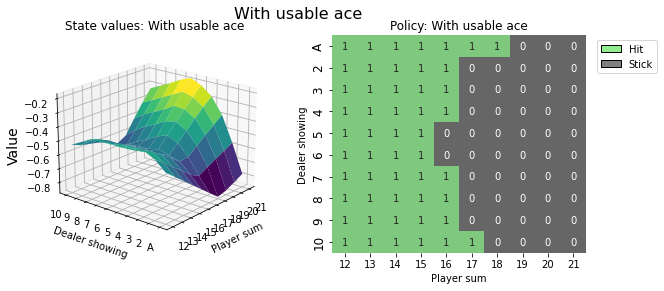

In [16]:
basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])

fig = create_plots(value_grid, basic_strategy_grid, title="With usable ace")
plt.show()


In [19]:
import numpy as np 
import pickle 

basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])

np.save('basic_strategy_grid.npy', basic_strategy_grid)

policy_grid = np.load('basic_strategy_grid.npy')

policy_grid


array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

In [ ]:
(9, 7, 0)